In [1]:
import torchvision
from torchvision import datasets
from torchvision import transforms

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

BATCH_SIZE = 256

trainset = datasets.CIFAR10(root='./data',
                            train=True,
                            download=True,
                            transform=transform)

valset = datasets.CIFAR10(root='./data',
                          train=False,
                          download=True,
                          transform=transform)

loaders = {
    'train': torch.utils.data.DataLoader(trainset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=2),

    'test': torch.utils.data.DataLoader(valset,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=2)
}

classes = ('plane', 'car', 'birb', 'meow', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12856833.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


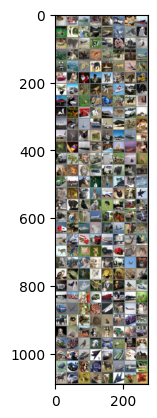

tensor([3, 9, 8, 4, 7, 0, 3, 8, 4, 5, 2, 8, 0, 4, 0, 5, 4, 5, 0, 3, 1, 5, 0, 2,
        0, 5, 7, 4, 6, 2, 7, 0, 5, 0, 6, 3, 8, 4, 2, 2, 1, 3, 5, 9, 3, 6, 3, 9,
        0, 9, 4, 2, 3, 8, 9, 5, 1, 5, 4, 5, 6, 6, 7, 5, 7, 4, 9, 3, 8, 4, 1, 0,
        8, 1, 8, 9, 0, 0, 7, 6, 0, 2, 3, 7, 3, 0, 8, 4, 6, 2, 8, 3, 5, 4, 8, 4,
        9, 6, 9, 1, 9, 4, 2, 2, 3, 6, 5, 1, 9, 3, 3, 7, 9, 9, 7, 5, 2, 3, 3, 8,
        3, 6, 1, 5, 0, 3, 5, 0, 3, 3, 2, 3, 2, 3, 1, 3, 3, 2, 5, 0, 9, 7, 4, 1,
        9, 5, 8, 5, 6, 0, 7, 6, 8, 8, 9, 9, 8, 9, 4, 6, 4, 0, 3, 2, 9, 9, 3, 6,
        5, 9, 5, 5, 5, 7, 0, 3, 2, 6, 3, 0, 6, 5, 6, 3, 1, 5, 8, 4, 5, 9, 2, 1,
        8, 9, 5, 1, 8, 7, 0, 4, 1, 0, 5, 6, 8, 4, 0, 3, 7, 2, 6, 6, 2, 7, 9, 8,
        5, 2, 7, 5, 5, 9, 3, 1, 1, 9, 2, 5, 0, 2, 3, 5, 6, 5, 1, 0, 8, 8, 5, 7,
        2, 1, 5, 5, 7, 8, 8, 4, 7, 1, 2, 2, 2, 0, 4, 0])
meow truck ship deer


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imgshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(loaders['train'])
images, labels = next(dataiter)

imgshow(torchvision.utils.make_grid(images))
print(labels)
print(' '.join('%s' % classes[labels[j]] for j in range(4)))

array([[ 62,  46,  48, ..., 132, 125, 124],
       [ 20,   0,   8, ...,  88,  83,  87],
       [ 24,   7,  27, ...,  84,  84,  73],
       ...,
       [170, 153, 161, ..., 133,  31,  34],
       [139, 123, 144, ..., 148,  62,  53],
       [144, 129, 142, ..., 184, 118,  92]], dtype=uint8)
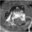

In [5]:
trainset.data[0, :, :, 1]

In [6]:
trainset.targets[:10]

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    # input is color image, so we have 3 channels RGB. 16 filters, kernel is 3x3
    self.conv1 = nn.Conv2d(in_channels=3,
                           out_channels=16,
                           kernel_size=3,
                           stride=1,
                           padding=1)
    # we double the number of feature maps for every conv layer as in practice it's good
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    # number of in_features is defined by output of conv layers: 64 of 4x4 feature maps
    self.fc1 = nn.Linear(in_features=4*4*64, out_features=512)
    self.dropout1 = nn.Dropout(0.2)
    self.fc2 = nn.Linear(512, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x)) # Apply ReLU to each output of conv layer
    x = F.max_pool2d(x, 2, 2) # Maxpooling layer with kernel of 2 and stride of 2
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)

    x = x.view(-1, 4*4*64) # flatten image to pass to linear layer
    x = F.relu(self.fc1(x))
    x = self.dropout1(x) # dropout regularization
    x = self.fc2(x)

    return x


In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = CNN().to(device)

cuda:0


In [14]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))


In [15]:
EPOCHS = 15

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for epoch in range(EPOCHS):

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for batch_id, (inputs, targets) in enumerate(loaders['train']):
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs)             # Feedforward every batch of 256 images
    loss = loss_fn(outputs, targets)    # Calc loss after each batch
    optimizer.zero_grad()               # Zero out accumulated gradients
    loss.backward()                     # Backpropagate loss function
    optimizer.step()                    # Update params after each step
    _, pred = torch.max(outputs, 1)
    # pred = outputs.argmax(dim=1, keepdim=False)
    running_loss += loss.item()
    running_corrects += torch.sum(pred == targets.data)
    # if batch_id % 50 == 0:
    #   print(f'Train Epoch: {epoch} [{batch_id * len(inputs)}/{len(loaders["train"].datatset)} ({batch_id / len(loaders["train"]):.0%})]\t{loss.item{}:.6}')


  with torch.no_grad():
    for val_inputs, val_targets in loaders['test']:
      val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
      val_outputs = model(val_inputs)
      val_loss = loss_fn(val_outputs, val_targets)

      _, val_pred = torch.max(val_outputs, 1)
      # val_pred = val_outputs.argmax(dim=1, keepdim=False)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_pred == val_targets.data)

  epoch_loss = running_loss/(len(loaders['train'])*BATCH_SIZE) #loss per epoch
  epoch_acc = running_corrects.float()/(len(loaders['train'])*BATCH_SIZE) # accuracy per epoch
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc.cpu().numpy())

  val_epoch_loss = val_running_loss/(len(loaders['test'])*BATCH_SIZE)
  val_epoch_acc = val_running_corrects.float()/(len(loaders['test'])*BATCH_SIZE) # accuracy per epoch
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc.cpu().numpy())
  print('Epoch:', (epoch+1))
  print(f'Training loss: {epoch_loss:.4}, Accuracy: {epoch_acc.item()}')
  print(f'Validation loss: {val_epoch_loss:.4}, Accuracy: {val_epoch_acc.item()}')


Epoch: 1
Training loss: 0.00799, Accuracy: 0.2373046875
Validation loss: 0.006936, Accuracy: 0.33349609375
Epoch: 2
Training loss: 0.006423, Accuracy: 0.3901865482330322
Validation loss: 0.006045, Accuracy: 0.41679689288139343
Epoch: 3
Training loss: 0.005941, Accuracy: 0.44046953320503235
Validation loss: 0.00619, Accuracy: 0.42207032442092896
Epoch: 4
Training loss: 0.005688, Accuracy: 0.4672951102256775
Validation loss: 0.005638, Accuracy: 0.46455079317092896
Epoch: 5
Training loss: 0.005457, Accuracy: 0.48985570669174194
Validation loss: 0.005446, Accuracy: 0.4847656190395355
Epoch: 6
Training loss: 0.005346, Accuracy: 0.5012156963348389
Validation loss: 0.00548, Accuracy: 0.47773438692092896
Epoch: 7
Training loss: 0.005231, Accuracy: 0.5130540132522583
Validation loss: 0.005612, Accuracy: 0.47343751788139343
Epoch: 8
Training loss: 0.005138, Accuracy: 0.5229192972183228
Validation loss: 0.005212, Accuracy: 0.517285168170929
Epoch: 9
Training loss: 0.005058, Accuracy: 0.5332230329

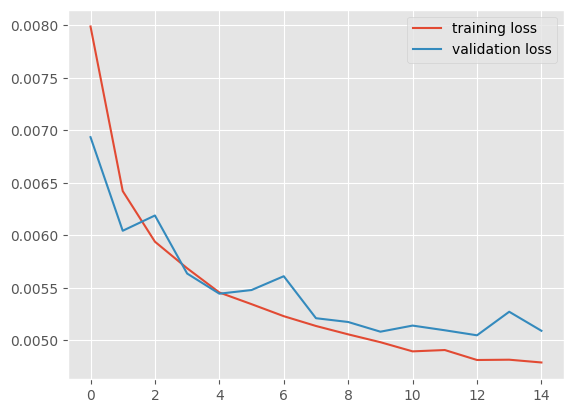

In [16]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

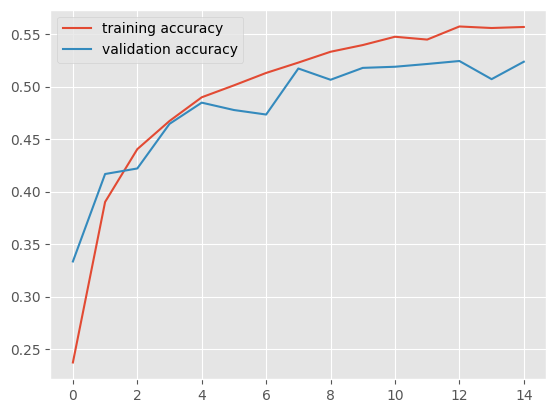

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()
plt.show()

In [18]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)